In [ ]:
import gdown

train_file_id = "1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX&export=download&authuser=0&confirm=t&uuid=b95b4297-9c61-42f8-a501-4d62f585546c&at=AN_67v3oaLEb9cS4k8wNadaTebci%3A1729526518538"
download_url = "https://drive.google.com/uc?id={}".format(train_file_id)
gdown.download(download_url, quiet=False)

In [ ]:
validation_file_id = "1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT&export=download&authuser=0"
download_url = "https://drive.google.com/uc?id={}".format(validation_file_id)
gdown.download(download_url, quiet=False)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.Preparing Train Dataset

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/car_img-test.zip', 'r') as file:
    file.extractall('train_dataset')

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/car_img-validation.zip', 'r') as file:
    file.extractall('validation_dataset')

In [5]:
import os

train_folder = 'train_dataset/train/'
image_files = [f for f in os.listdir(train_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

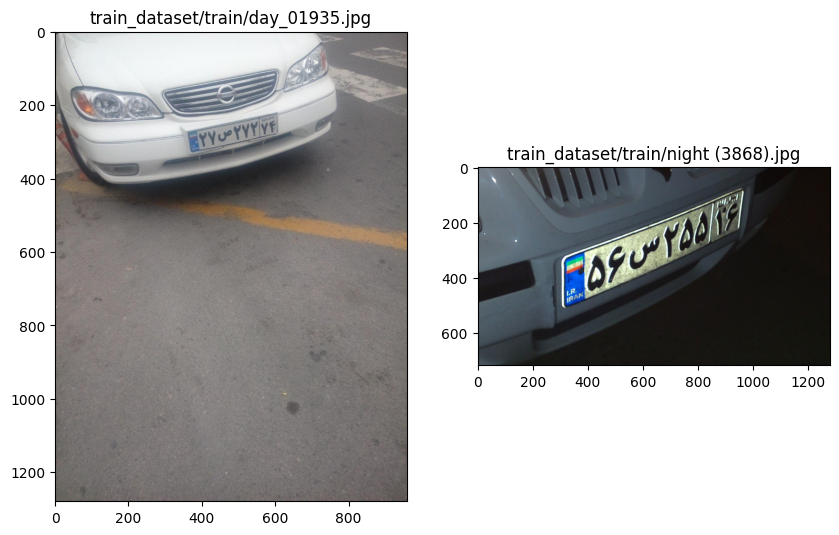

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(train_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [7]:
len(image_files)

4176

### Separate images taken in day

In [8]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

3351

### Separate Train Labels related to images in day

In [9]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

3351

In [10]:
from bs4 import BeautifulSoup


def calc_plate_area(plate_info):
    xmax = int(plate_info.find('xmax').text)
    xmin = int(plate_info.find('xmin').text)
    ymax = int(plate_info.find('ymax').text)
    ymin = int(plate_info.find('ymin').text)

    return (xmax - xmin) * (ymax - ymin)


def extract_plate_numbers(label_file):
    plate_char_num = 8

    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    plate_numbers = list(filter(lambda tag: tag.text != 'کل ناحیه پلاک', bs_data.find_all('name')))
    plate_numbers = list(map(lambda tag: tag.text, plate_numbers))
    plate_numbers = [plate_numbers[i: i + plate_char_num] for i in range(0, len(plate_numbers), plate_char_num)]

    file.close()

    return plate_numbers


def extract_plate_coordinates(label_file):
    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    matches = list(filter(lambda t: t.find('name').text == 'کل ناحیه پلاک', bs_data.find_all('object')))
    plate = max(matches, key = lambda p: calc_plate_area(p))
    plate = [int(plate.find('xmax').text), int(plate.find('xmin').text), int(plate.find('ymax').text), int(plate.find('ymin').text)]

    file.close()

    return plate

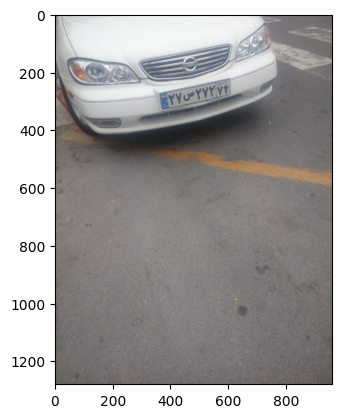

In [11]:
plt.imshow(plt.imread(train_folder + image_files[0]))

In [12]:
extract_plate_numbers(os.path.join(train_folder, label_files[0]))

[['2', '7', 'ص', '2', '7', '2', '7', '4']]

In [13]:
extract_plate_coordinates(os.path.join(train_folder, label_files[0]))

[604, 362, 329, 226]

### Converting all xml content to plate coordinates

In [14]:
train_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(train_folder, label_files[i]))
    train_labels.append(plate)

### Normalizing data for adjusting brightness on train and validation data(in HSV dim)

In [15]:
import cv2

# Define folders
input_folder = '/content/train_dataset/train'
output_folder = '/content/train_dataset/train_normalized_image'
os.makedirs(output_folder, exist_ok=True)

def normalize_hsv(img):
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the HSV channels
    h, s, v = cv2.split(hsv_img)

    # Normalize the Value channel
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)

    # Merge back the channels
    normalized_img = cv2.merge([h, s, v])

    # Convert back to RGB
    normalized_img = cv2.cvtColor(normalized_img, cv2.COLOR_HSV2RGB)

    return normalized_img

# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'train_dataset/train_normalized_image' folder.")

Images have been normalized and saved in the 'train_dataset/train_normalized_image' folder.


In [16]:
# Define folders
input_folder = '/content/validation_dataset/validation'
output_folder = '/content/validation_dataset/validation_normalized_image'
os.makedirs(output_folder, exist_ok=True)


# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'validation_dataset/validation_normalized_image' folder.")

Images have been normalized and saved in the 'validation_dataset/validation_normalized_image' folder.


### Converting Images to (1280, 1280, 3)(batching method)

In [17]:
#get the maximum width and height

from PIL import Image
import os

folder_path = 'train_dataset/train/'
max_width = 0
max_height = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)

print("Max width (x):", max_width)
print("Max height (y):", max_height)

Max width (x): 1280
Max height (y): 1280


### using batch on train data for preventing ram overflow

In [18]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'train_dataset/train_normalized_image'
output_folder = 'train_dataset/train_resized_image'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]

    for filename in batch:
        img_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height

            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)

            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)

            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

Processed batch 1 of 42
Processed batch 2 of 42
Processed batch 3 of 42
Processed batch 4 of 42
Processed batch 5 of 42
Processed batch 6 of 42
Processed batch 7 of 42
Processed batch 8 of 42
Processed batch 9 of 42
Processed batch 10 of 42
Processed batch 11 of 42
Processed batch 12 of 42
Processed batch 13 of 42
Processed batch 14 of 42
Processed batch 15 of 42
Processed batch 16 of 42
Processed batch 17 of 42
Processed batch 18 of 42
Processed batch 19 of 42
Processed batch 20 of 42
Processed batch 21 of 42
Processed batch 22 of 42
Processed batch 23 of 42
Processed batch 24 of 42
Processed batch 25 of 42
Processed batch 26 of 42
Processed batch 27 of 42
Processed batch 28 of 42
Processed batch 29 of 42
Processed batch 30 of 42
Processed batch 31 of 42
Processed batch 32 of 42
Processed batch 33 of 42
Processed batch 34 of 42
Processed batch 35 of 42
Processed batch 36 of 42
Processed batch 37 of 42
Processed batch 38 of 42
Processed batch 39 of 42
Processed batch 40 of 42
Processed

### using batch on validation for preventing ram overflow

In [19]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'validation_dataset/validation_normalized_image'
output_folder = 'validation_dataset/validation_resized_image'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]

    for filename in batch:
        img_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height

            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)

            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)

            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

Processed batch 1 of 22
Processed batch 2 of 22
Processed batch 3 of 22
Processed batch 4 of 22
Processed batch 5 of 22
Processed batch 6 of 22
Processed batch 7 of 22
Processed batch 8 of 22
Processed batch 9 of 22
Processed batch 10 of 22
Processed batch 11 of 22
Processed batch 12 of 22
Processed batch 13 of 22
Processed batch 14 of 22
Processed batch 15 of 22
Processed batch 16 of 22
Processed batch 17 of 22
Processed batch 18 of 22
Processed batch 19 of 22
Processed batch 20 of 22
Processed batch 21 of 22
Processed batch 22 of 22


(1280, 1280, 3)


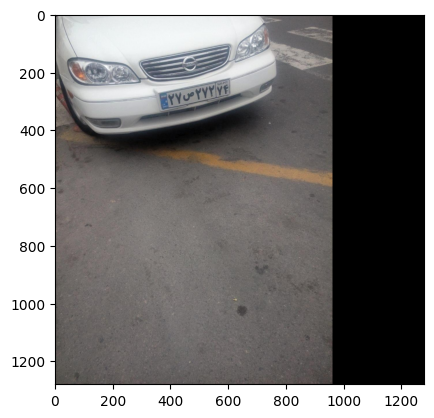

In [20]:
sample = plt.imread('train_dataset/train_resized_image/' + image_files[0])

print(sample.shape)
plt.imshow(sample)

In [21]:
extract_plate_numbers(os.path.join(train_folder, label_files[0]))

[['2', '7', 'ص', '2', '7', '2', '7', '4']]

In [22]:
extract_plate_coordinates(os.path.join(train_folder, label_files[0]))

[604, 362, 329, 226]

### 2.Preparing Validation dataset

In [23]:
import os

validation_folder = 'validation_dataset/validation/'
image_files = [f for f in os.listdir(validation_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

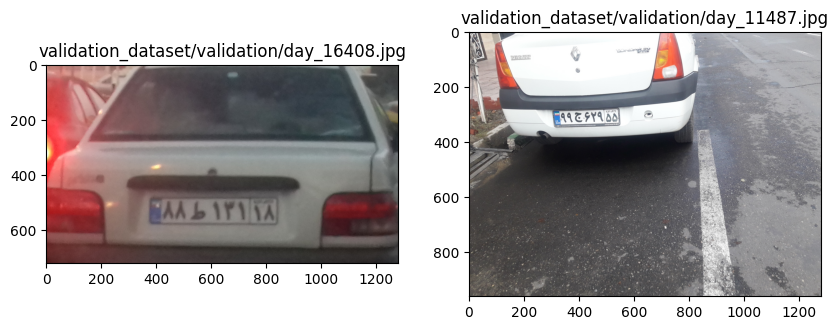

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(validation_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [25]:
len(image_files)

2120

### Separate images taken in day

In [26]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

1708

### Separate Validation Labels related to images in day

In [27]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

1708

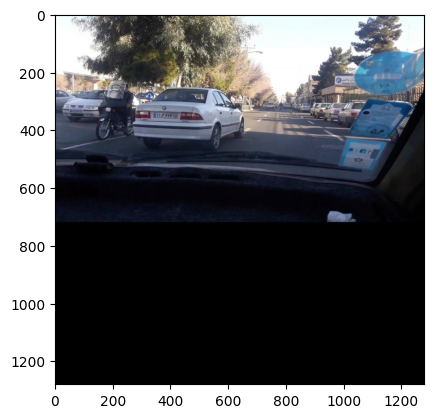

In [28]:
plt.imshow(plt.imread('validation_dataset/validation_resized_image/' + image_files[48]))

In [29]:
extract_plate_numbers(os.path.join(validation_folder, label_files[48]))

[['1', '1', 'م', '6', '7', '6', '1', '6']]

In [30]:
extract_plate_coordinates(os.path.join(validation_folder, label_files[48]))

[425, 339, 362, 343]

### Converting all xml content to plate coordinates

In [31]:
validation_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(validation_folder, label_files[i]))
    validation_labels.append(plate)

### Preparaing Train and Validation Dataset for model

In [ ]:
#train_images = np.array(train_images)
#validation_images = np.array(validation_images)

#train_labels = np.array(train_labels)
#validation_labels = np.array(validation_labels)

In [ ]:
#train_images.shape, validation_images.shape, train_labels.shape, validation_labels.shape

### Creating model for training plate coordinates

In [ ]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(2))

model.summary()